In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
# Need to use below username/pw/token to authenticate to my dataset (since it's public data, I'm ok with sharing
# Otherwise, I would've stored as an environmental variable on my local machine (but don't want professor to have
# to do that to run my code:
client = Socrata('opendata.maryland.gov',
                 '[Insert API Key Here]',
                 "[Insert Email Here]",
                 "[Insert Password Here]")
#https://opendata.maryland.gov/resource/f3nd-cfdf.json
# dictionaries by sodapy.
results = client.get("f3nd-cfdf", limit=15000)


In [3]:
results_df = pd.DataFrame.from_records(results)


In [4]:
# Convert to pandas DataFrame

#Update column names for easier understanding
results_df.rename(columns={'land_use_code_mdp_field_lu_desclu_sdat_field_50':'LandUseCode',
                          'county_name_mdp_field_cntyname':'CountyName',
                          'additional_c_a_m_a_data_dwelling_type_mdp_field_strubldg_sdat_field_265':'DwellingType',
                           'date_of_most_recent_open_data_portal_record_update':'TimeofLastDataUpdate',
                           'assessment_cycle_year_sdat_field_399':'CurrentAssessmentYear',
                           'file_record_type_sdat_field_400':'FileRecordType',
                           'jurisdiction_code_mdp_field_jurscode':'CountyCode',
                           'account_id_mdp_field_acctid':'MDPAccountID',
                           'mdp_street_address_mdp_field_address':'StreetAddress',
                           'additional_c_a_m_a_data_building_style_code_and_description_mdp_field_strustyl_descstyl_sdat_field_264':'BuildingStyleCodeandDescription',
                           'c_a_m_a_system_data_number_of_dwelling_units_mdp_field_bldg_units_sdat_field_239':'NoofUnitsinDwelling',
                           'c_a_m_a_system_data_year_built_yyyy_mdp_field_yearblt_sdat_field_235':'YearBuilt',
                           'mdp_street_address_city_mdp_field_city':'CityName',
                           'c_a_m_a_system_data_structure_area_sq_ft_mdp_field_sqftstrc_sdat_field_241':'SizeofHouse',
                           'mdp_street_address_type_code_mdp_field_resityp':'StreetAddressType',
                           'c_a_m_a_system_data_number_of_stories_mdp_field_bldg_story_sdat_field_240':'NoofStories',
                           'mdp_street_address_zip_code_mdp_field_zipcode':'ZipCode',
                           'current_assessment_year_total_assessment_sdat_field_172':'HousingSalesPrice',
                           'prior_assessment_year_total_assessment_sdat_field_161':'PriorYearHousingSalesPrice',
                           'mdp_street_address_units_mdp_field_strtunt':'StreetAddressUnits',
                           'c_a_m_a_system_data_dwelling_grade_code_and_description_mdp_field_strugrad_strudesc_sdat_field_230':'DwellingGrade'                         
                          },
                  inplace=True)

#Clean Up DwellingType Column
results_df['DwellingType'] = results_df['DwellingType'].str[4:]
results_df['DwellingType'] = results_df['DwellingType'].str[:-6]

#Update No of Stories from Building Style Code & Description
results_df['NoofStories'] = results_df['BuildingStyleCodeandDescription'].str.rsplit(r" Story").str[0]

#Add a new column to show if house has basement or no basement
results_df['HasBasement'] = results_df['BuildingStyleCodeandDescription'].str.split(r"(").str[0]
results_df['HasBasement'] = results_df['HasBasement'].str.rsplit(r"Story").str[1]

#Additional filter where year built <> '0000'
results_df = results_df[results_df.YearBuilt != '0000']


In [5]:
#Remove homes that do not have a record of a basement
results_df = results_df.dropna(subset=['HasBasement'])


In [6]:
#remove extra text from NoofStories
results_df['NoofStories'] = results_df['NoofStories'].map(lambda x: x.lstrip('STRY'))
results_df['NoofStories'] = results_df['NoofStories'].map(lambda x: x.lstrip('TH '))
results_df['NoofStories'] = results_df['NoofStories'].map(lambda x: x.lstrip('Center'))
results_df['NoofStories'] = results_df['NoofStories'].map(lambda x: x.lstrip('End '))

In [7]:
#remove extra text from Dwelling Grade
results_df['DwellingGrade'] = results_df['DwellingGrade'].str.rsplit(r"(").str[1]
results_df['DwellingGrade'] = results_df['DwellingGrade'].map(lambda x: x.rstrip(')'))

In [8]:
#Update columns we know are integers & contiuous
results_df["YearBuilt"] = results_df["YearBuilt"].astype(str).astype(int)
results_df["SizeofHouse"] = results_df["SizeofHouse"].astype(str).astype(int)
results_df["HousingSalesPrice"] = results_df["HousingSalesPrice"].astype(str).astype(int)
results_df["PriorYearHousingSalesPrice"] = results_df["PriorYearHousingSalesPrice"].astype(str).astype(int)
results_df["CurrentAssessmentYear"] = results_df["CurrentAssessmentYear"].astype(str).astype(int)
results_df['DwellingGrade'] = results_df['DwellingGrade'].astype(str).astype(int)
results_df['NoofUnitsinDwelling']= results_df['NoofUnitsinDwelling'].astype(str).astype(int)

In [9]:
#Create a HouseAge column to add to our model
results_df["HouseAge"] = results_df["CurrentAssessmentYear"] - results_df["YearBuilt"]
results_df.reset_index(drop=True,inplace=True)

In [10]:
results_df.to_pickle('MDHousingDataset.pickle')


## Basic statistics on the data

In [11]:
targetvariablebasicstats = results_df[['HousingSalesPrice','NoofStories','HouseAge','PriorYearHousingSalesPrice']]
df = (targetvariablebasicstats.assign(Data_Value=targetvariablebasicstats['HousingSalesPrice'].abs())
       .groupby(['NoofStories'])['HousingSalesPrice'].agg([('Min' , 'min'), ('Max', 'max'),('Mean','mean'),('Median','median'),('Standard Deviation','std')])
       )

df.to_excel('basichousepricestats.xlsx')
df

,Min,Max,Mean,Median,Standard Deviation
NoofStories,,,,,
1,91300,822367,259366.850995,244900,74066.220747
1 1/2,79900,743600,290912.992252,275567,84632.234346
2,56800,1096600,292155.052781,268250,113387.185454
2 1/2,152433,1575300,418182.830928,403867,138681.737408
3,199067,897500,450585.935484,401233,152499.280856


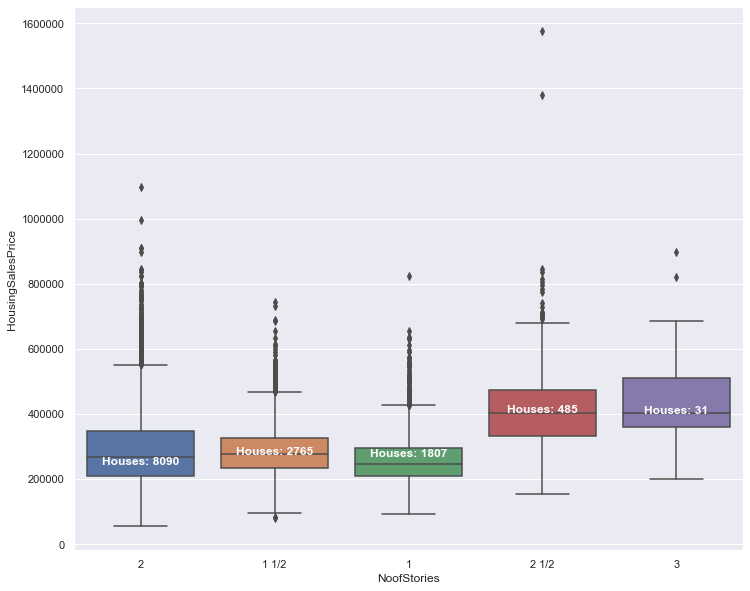

In [12]:
df = boxplotdata = results_df[['HousingSalesPrice','NoofStories','HouseAge']]
sns.set(rc={'figure.figsize':(12,10)})
ax = sns.boxplot(x="NoofStories", y="HousingSalesPrice", data=df)

# Calculate number of obs per group & median to position labels
medians = df.groupby(['NoofStories'])['HousingSalesPrice'].median().values
nobs = df['NoofStories'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["Houses: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.01, nobs[tick],
    horizontalalignment='center', color='w', weight='semibold')

plt.savefig('BoxPlot.png')

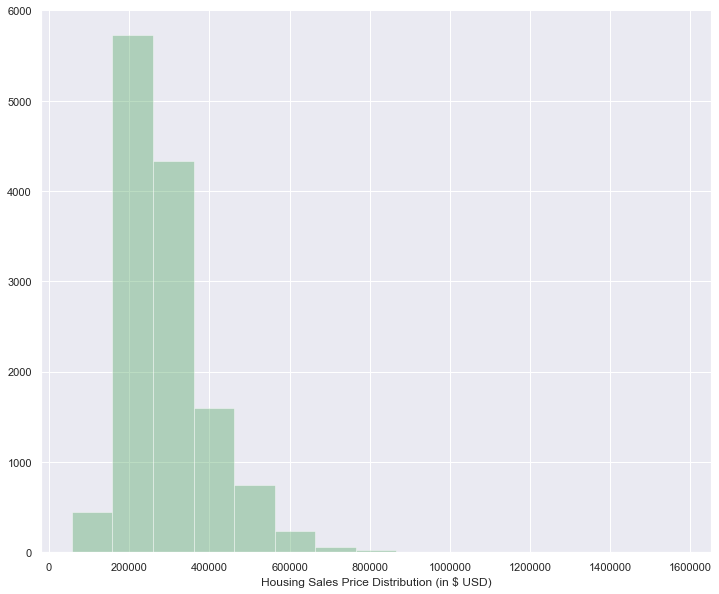

In [17]:
sns.set(rc={'figure.figsize':(12,10)})
plt.figure()
sns.distplot(targetvariablebasicstats['HousingSalesPrice'],color='g',bins=15,kde=False,axlabel='Housing Sales Price Distribution (in $ USD)')

plt.savefig('HSPDist.png')

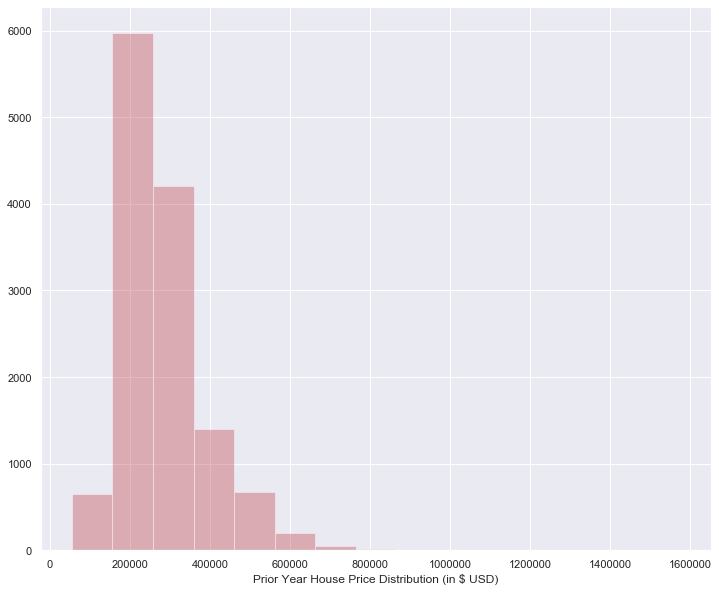

In [18]:
sns.set(rc={'figure.figsize':(12,10)})
plt.figure()
sns.distplot(targetvariablebasicstats['PriorYearHousingSalesPrice'],color='r',bins=15,kde=False,axlabel='Prior Year House Price Distribution (in $ USD)')


plt.savefig('PYHSPDist.png')

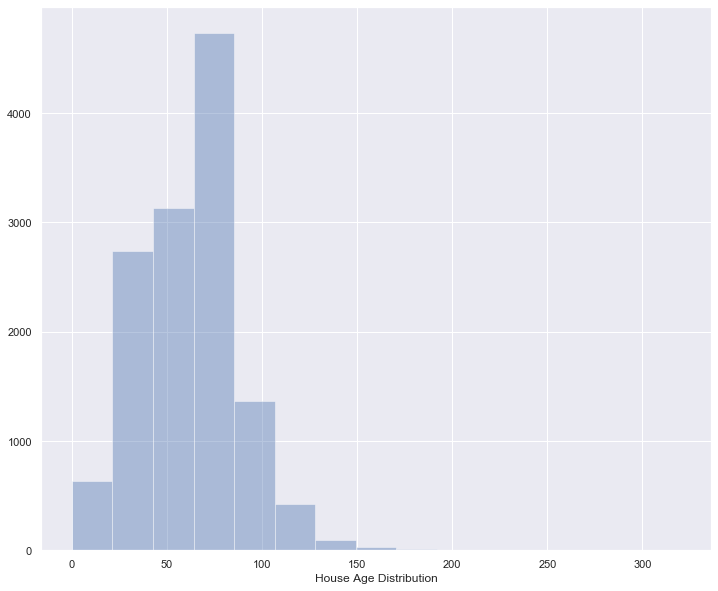

In [19]:
sns.set(rc={'figure.figsize':(12,10)})
plt.figure()
sns.distplot(targetvariablebasicstats['HouseAge'],color='b',bins=15,kde=False,axlabel='House Age Distribution')


plt.savefig('HADist.png')